<a href="https://colab.research.google.com/github/nhatpd/2021-Summer-School/blob/main/Implementation-of-PG-for-linear-logistic-regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implement (proximal) gradient algorithms for regression models:
1. Linear regression with lasso
2. logistic regression with lasso

# Experiment on red wine quality

In [2]:
import pandas as pd
red_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv',sep = ';')
X = red_wine.drop(['quality'],axis =1)
y = red_wine['quality']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_tr_prepared = std.fit_transform(X_train)

X_t_prepared = std.transform(X_test)

# Implementation of l1-regularized linear regression model

In [3]:
import numpy as np
def LinearPredict(w, X_test):
  n, d = X_test.shape
  X_test = np.c_[np.ones((n, 1)), X_test]
  return X_test.dot(w)

In [4]:
def soft_thresholding(v, gamma):
  return np.sign(v)*np.maximum(np.abs(v) - gamma,0)

In [107]:
def Train_LinearR(X_train, y_train, w0, eta = 0.1, maxIter = 1000, alpha = 0.1):
  n, d = X_train.shape

  X_train = np.c_[np.ones((n, 1)), X_train]
  XTy = X_train.T.dot(y_train)

  w = w0

  Xw = X_train.dot(w)
  
  for iter in range(maxIter):
    grad = 2/n * (X_train.T.dot(Xw) - XTy)
    v = w - eta * grad
    w = soft_thresholding(v,eta*alpha)
    Xw = X_train.dot(w)
    
  return w

In [126]:
w0 = np.random.randn(X_tr_prepared.shape[1]+1)
w = Train_LinearR(X_tr_prepared,y_train,w0)

In [5]:
import time 

def LinearR(X_train, y_train, w0, X_val = None, y_val = None, eta = 0.1, maxIter = 1000, alpha = 0.1, maxTime = None, tol = None, early_stopping = None):
  n, d = X_train.shape

  Time = []
  Time.append(0)
  obj = []
  rmse_train = []
  rmse_val =[]
  nnz = []
  

  X_train = np.c_[np.ones((n, 1)), X_train]
  XTy = X_train.T.dot(y_train)
  
  w = w0
  nnz.append(np.count_nonzero(w))

  if early_stopping:
    min_rmse_val = float('inf')
  if X_val is not None:
    n_t = X_val.shape[0]
    y_hat = LinearPredict(w,X_val)
    rmse_val.append(np.sqrt(np.linalg.norm(y_hat - y_val)**2/n_t))

  Xw = X_train.dot(w)
  mse = np.linalg.norm(Xw - y_train)**2/n
  obj.append(mse + alpha*np.abs(w).sum())
  rmse_train.append(np.sqrt(mse))

  for iter in range(maxIter):
    start_time = time.time()

    grad = 2/n * (X_train.T.dot(Xw) - XTy)
    v = w - eta * grad
    w = soft_thresholding(v,eta*alpha)
    Xw = X_train.dot(w)

    Time.append(time.time() - start_time + Time[-1])
    mse = np.linalg.norm(Xw - y_train)**2/n
    obj.append(mse + alpha*np.abs(w).sum())
    rmse_train.append(np.sqrt(mse))
    nnz.append(np.count_nonzero(w))
    if X_val is not None:
      y_hat = LinearPredict(w,X_val)
      rmse_val.append(np.sqrt(np.linalg.norm(y_hat - y_val)**2/n_t))

    #stopping criterion
    if maxTime is not None:
      if Time[-1] > maxTime:
        print('Stopped by MaxTime at ',iter,'-th iterattion')
        break
    if tol is not None:
      if np.abs(obj[-1] - obj[-2]) <= tol:
        print('Stopped by objective value at ',iter,'-th iterattion')
        break
    if early_stopping:
      if rmse_val[-1] < min_rmse_val:
        min_rmse_val = rmse_val[-1]
      else:
        print('Stopped by early stopping at ',iter,'-th iterattion')
        break
    
  return w, obj, Time, rmse_train, nnz, rmse_val

In [5]:
w0 = np.random.randn(X_tr_prepared.shape[1]+1)
res = LinearR(X_tr_prepared,y_train,w0 = w0, X_val=X_t_prepared,y_val = y_test,early_stopping=True,maxIter=1000)

In [6]:
min(res[5])

0.6454738181687202

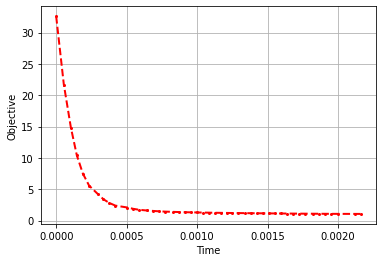

In [9]:
import matplotlib.pyplot as plt

plt.plot(res[2], res[1], 'o-', color='red', markersize=2, linewidth =2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Objective')
plt.grid(True)

In [173]:
class Linear_R:

  def __init__(self, w0, eta = 0.1, maxIter = 1000, alpha = 0.1, maxTime = None, tol = None):

    self.w = w0
    self.eta = eta
    self.maxIter = maxIter
    self.alpha = alpha
    self.maxTime = maxTime
    self.tol = tol

  def soft_thresholding(self, v, gamma):
    return np.sign(v)*np.maximum(np.abs(v) - gamma,0)

  def fit(self, X_train, y_train):

    n, d = X_train.shape

    Time = []
    Time.append(0)
    obj = []
    rmse_train = []
    
    X_train = np.c_[np.ones((n, 1)), X_train]
    XTy = X_train.T.dot(y_train)

    Xw = X_train.dot(self.w)
    mse = np.linalg.norm(Xw - y_train)**2/n
    obj.append(mse + self.alpha*np.abs(self.w).sum())
    rmse_train.append(np.sqrt(mse))
    for iter in range(self.maxIter):
      start_time = time.time()

      grad = 2/n * (X_train.T.dot(Xw) - XTy)
      v = self.w - self.eta * grad
      self.w = self.soft_thresholding(v,self.eta*self.alpha)
      Xw = X_train.dot(self.w)

      Time.append(time.time() - start_time + Time[-1])
      mse = np.linalg.norm(Xw - y_train)**2/n
      obj.append(mse + self.alpha*np.abs(self.w).sum())
      rmse_train.append(np.sqrt(mse))

      #stopping conditions
      if self.maxTime is not None:
        if Time[-1] > self.maxTime:
          print('Stopped by MaxTime at ',iter,'-th iterattion')
          break
      if self.tol is not None:
        if np.abs(obj[-1] - obj[-2]) <= self.tol:
          print('Stopped by the objective value at ',iter,'-th iterattion')
          break
      
    return obj, Time, rmse_train
  def predict(self, X_test):
    n, d = X_test.shape
    X_test = np.c_[np.ones((n, 1)), X_test]
    return X_test.dot(self.w)

In [174]:
w0 = np.random.randn(X_tr_prepared.shape[1]+1)
model = Linear_R(w0,maxTime=1)
res = model.fit(X_tr_prepared,y_train)

# Experiment on BlogFeedback

In [6]:
!pip install wget
import wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=8485e48234d899f88d07bcdaec832d44c597db4e5a73262f0dc0e9eb2aabf797
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [11]:
wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip','BlogFeedback.zip')
!unzip BlogFeedback.zip

Archive:  BlogFeedback.zip
  inflating: blogData_test-2012.02.01.00_00.csv  
  inflating: blogData_test-2012.02.02.00_00.csv  
  inflating: blogData_test-2012.02.03.00_00.csv  
  inflating: blogData_test-2012.02.04.00_00.csv  
  inflating: blogData_test-2012.02.05.00_00.csv  
  inflating: blogData_test-2012.02.06.00_00.csv  
  inflating: blogData_test-2012.02.07.00_00.csv  
  inflating: blogData_test-2012.02.08.00_00.csv  
  inflating: blogData_test-2012.02.09.00_00.csv  
  inflating: blogData_test-2012.02.10.00_00.csv  
  inflating: blogData_test-2012.02.11.00_00.csv  
  inflating: blogData_test-2012.02.12.00_00.csv  
  inflating: blogData_test-2012.02.13.00_00.csv  
  inflating: blogData_test-2012.02.14.00_00.csv  
  inflating: blogData_test-2012.02.15.00_00.csv  
  inflating: blogData_test-2012.02.16.00_00.csv  
  inflating: blogData_test-2012.02.17.00_00.csv  
  inflating: blogData_test-2012.02.18.00_00.csv  
  inflating: blogData_test-2012.02.19.00_00.csv  
  inflating: blogData_t

In [12]:
train = pd.read_csv('blogData_train.csv',header = None)
test = pd.read_csv('blogData_test-2012.03.31.01_00.csv',header = None)
X_train = train.drop([280],axis =1)
y_train = train[280]

X_test = test.drop([280],axis =1)
y_test = test[280]

std = StandardScaler()
X_tr_prepared = std.fit_transform(X_train)
X_t_prepared = std.transform(X_test)

In [22]:
w0 = np.random.randn(X_tr_prepared.shape[1]+1)
res = LinearR(X_tr_prepared,y_train,w0 = w0, X_val=X_t_prepared,y_val = y_test,early_stopping=False,maxIter=1000, eta =0.01,tol =1e-4,alpha = 2)

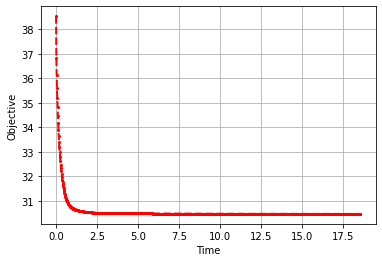

In [28]:
import matplotlib.pyplot as plt

plt.plot(res[2], res[3], 'o-', color='red', markersize=2, linewidth =2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Objective')
plt.grid(True)

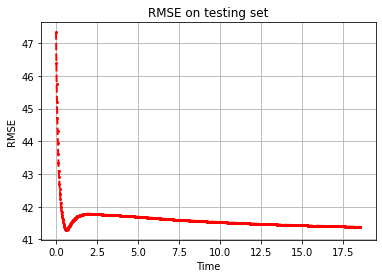

In [23]:
import matplotlib.pyplot as plt

plt.plot(res[2], res[5], 'o-', color='red', markersize=2, linewidth =2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('RMSE')
plt.title("RMSE on testing set")
plt.grid(True)

Practice:

1. Implement Ride and Elastic Net regressions
2. Compute the Lipschitz constant and train models with this learning rate
3. Implement early_stopping using class Linear_R without modifying

# Logistic regression model

Experiment on GISETTE

In [7]:
wget.download('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.bz2','gisette_scale.bz2')
wget.download('https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/gisette_scale.t.bz2','gisette_scale.t.bz2')

'gisette_scale.t.bz2'

In [8]:
!bunzip2 gisette_scale.bz2
!bunzip2 gisette_scale.t.bz2

In [9]:
!pip install libsvm
from libsvm.svmutil import svm_read_problem

     |████████████████████████████████| 170 kB 11.3 MB/s 
  Created wheel for libsvm: filename=libsvm-3.23.0.4-cp37-cp37m-linux_x86_64.whl size=233363 sha256=d98ca6c4911c0f815d01c384d7702d53ae1c2f882d0ac7bc694e00435224bf95
  Stored in directory: /root/.cache/pip/wheels/cd/e8/1e/bf95cf256e4d3ffc94289ab508c49d48e34c98220af63e3513
Successfully built libsvm


In [10]:
y_train, X_train = svm_read_problem('gisette_scale')
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
X_train = v.fit_transform(X_train)

In [11]:
y_test, X_test = svm_read_problem('gisette_scale.t')
X_test = v.transform(X_test)

In [12]:
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [73]:
from sklearn.metrics import accuracy_score
class LogisticR:

  def __init__(self, w0, eta = 0.1, maxIter = 1000, alpha = 0.1, maxTime = None, tol = None):

    self.w = w0
    self.eta = eta
    self.maxIter = maxIter
    self.alpha = alpha
    self.maxTime = maxTime
    self.tol = tol
    self.Time = []
    self.obj = []
    self.acc_train = []
    self.nnz = []

  def soft_thresholding(self, v, gamma):
    return np.sign(v)*np.maximum(np.abs(v) - gamma,0)

  def fit(self, X_train, y_train, eval = True):

    n, d = X_train.shape

    X_train = np.c_[np.ones((n, 1)), X_train]
    
    Xw = X_train.dot(self.w)

    for iter in range(self.maxIter):
      
      start_time = time.time()

      aa = y_train*Xw

      prob = 1/(1+np.exp(-aa))

      b = y_train*(1-prob)/n

      grad = X_train.T.dot(-b)

      v = self.w - self.eta * grad

      self.w = self.soft_thresholding(v,self.eta*self.alpha)

      Xw = X_train.dot(self.w)

      self.Time.append(time.time() - start_time)
      if eval:

        bb = np.maximum(-aa,0)
        f_val = (np.log(np.exp(-bb) +  np.exp(-aa-bb)) + bb).mean()
        self.obj.append(f_val + self.alpha*np.abs(self.w).sum())

        self.nnz.append(np.count_nonzero(self.w))

        y_pred = np.sign(Xw)
        y_pred[y_pred==0] = 1
        self.acc_train.append(accuracy_score(y_train,y_pred))
        #stopping conditions
        if self.maxTime is not None:
          if np.sum(self.Time) > self.maxTime:
            print('Stopped by MaxTime at ',iter,'-th iterattion')
            break
        if self.tol is not None:
          if np.abs(self.obj[-1] - self.obj[-2]) <= self.tol:
            print('Stopped by the objective value at ',iter,'-th iterattion')
            break

  def predict(self, X_test):
    n, d = X_test.shape
    X_test = np.c_[np.ones((n, 1)), X_test]
    y_pred = np.sign(X_test.dot(self.w))
    y_pred[y_pred==0] = 1
    return y_pred

In [77]:
w0 = np.zeros(X_train.shape[1]+1) #np.random.randn(X_test.shape[1]+1)
model = LogisticR(w0,eta = 0.01, alpha = 0.1, maxTime=100)
model.fit(X_train,y_train)

In [75]:
print(accuracy_score(y_test,model.predict(X_test)))

0.859


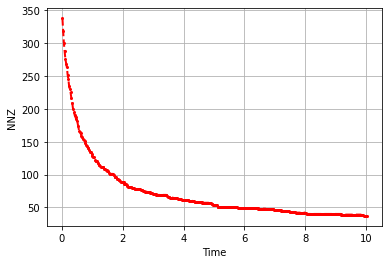

In [76]:
import matplotlib.pyplot as plt

plt.plot(np.cumsum(model.Time), model.nnz, 'o-', color='red', markersize=2, linewidth =2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('NNZ')
# plt.title("")
plt.grid(True)

Practice:

1. Implement an accelerated version for the logistic regression model
2. Implement early-stopping
3. Implement a bactracking line search